In [1]:
### FOR GOOGLE COLAB
from google.colab import drive
drive.mount('/content/drive/')
# %ls

# %ls
%cd drive/MyDrive/cs7643_fp
%ls

Mounted at /content/drive/
/content/drive/MyDrive/cs7643_fp
A172_test.json                   mrcnn_out/
Base-RCNN-FPN.yaml               mrcnn_out_2/
BT474_test.json                  mrcnn_proposal/
BV2_test.json                    mrcnn_random/
coco_file.yaml                   nn_results/
cocoScripts/                     output/
data/                            output_scratch/
default/                         output_scratch_temp/
detectron2-ResNeSt/              r50_detectron2_finetune_livecell.json
Huh7_test.json                   README.md
instructions.md                  segmentation_results/
LIVECell_anchor_based_model.pth  SHSY5Y_test.json
livecell_config.yaml             SkBr3_test.json
make_dataset.py                  SKOV3_test.json
maskrcnn/                        transformer/
MCF7_test.json                   wandb/
mrcnn_freeze/


In [2]:
#### NECESSARY PACKAGES
# !pip install git+https://github.com/facebookresearch/segment-anything.git
!python -m pip install -e detectron2-ResNeSt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/cs7643_fp/detectron2-ResNeSt
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.dev200407-py3-none-any.whl size=38761 sha256=d3e7c687055a78d483bcca8cbd86a3a82e851c292fad6948ea89bb8ad3af8995
  Stored in directory: /root/.cache/pip/wheels/e3/b3/b5/15b702800c0a8cd66c7a3a4b67f8267acaf43b068b2da1e662
Successfully built fvcore
  Running setup.py develop for detectron2


In [3]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!pip install imagecodecs
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

import torch
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.data.datasets import register_coco_instances
register_coco_instances("dataset_train", {}, "data/trainImgs.json", "data/images/livecell_train_val_images")
register_coco_instances("dataset_val", {}, "data/valImgs.json", "data/images/livecell_train_val_images")
register_coco_instances("dataset_test", {}, "data/testImgs.json", "data/images/livecell_test_images")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=a427304395138018051108ce770f048793f31725a49873a5c69e76e3ae778346
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.6.9 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatibl

In [5]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")  # Let training initialize from model zoo
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ("dataset_val")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.OUTPUT_DIR = "./default"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "mod1.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/04 01:30:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./default/mod1.pth ...


## Visualization

[05/04 01:31:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./default/mod1.pth ...


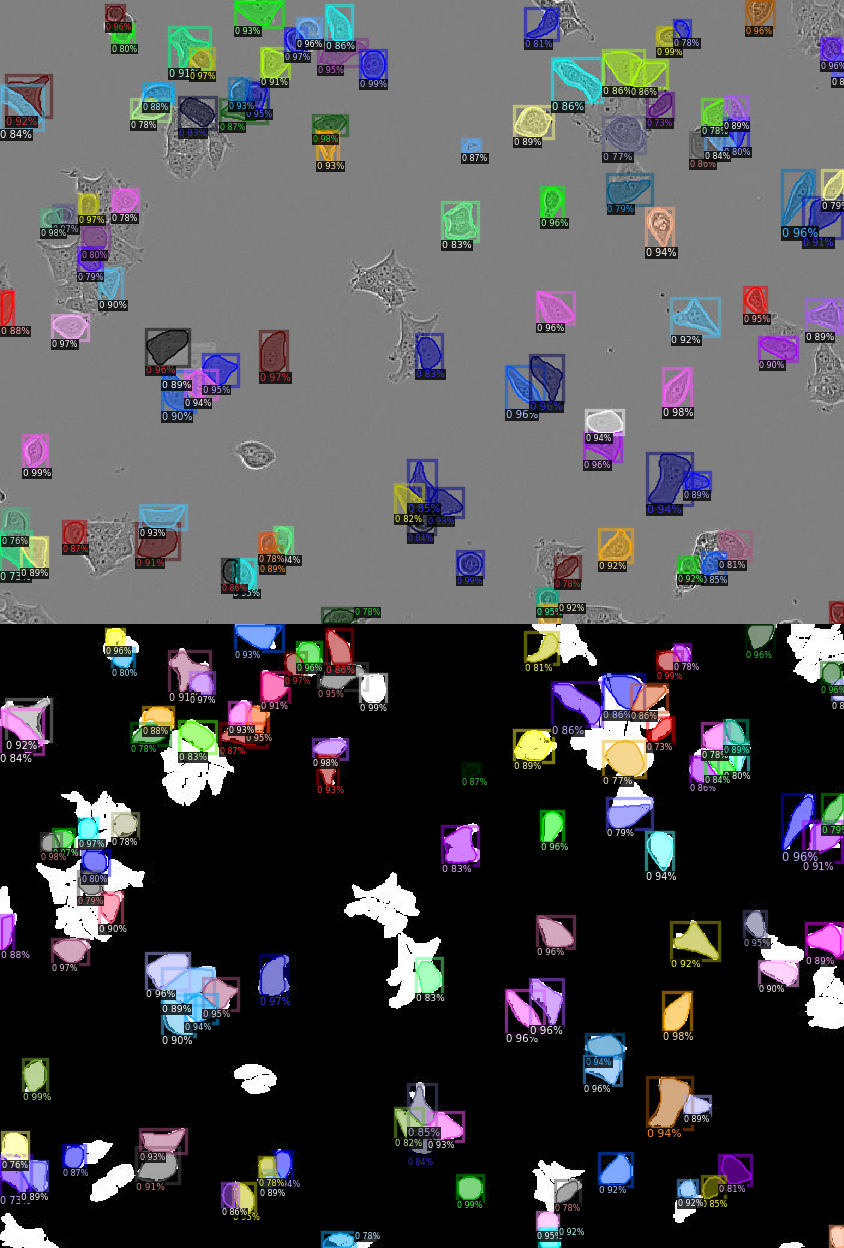

In [7]:
import cv2
import matplotlib.pyplot as plt

from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

# def cv2_imshow(im, bool_matplotlib=True):
#     if bool_matplotlib:
#         plt.imshow(im)
#         plt.show()
#     else:
#         cv2.imshow("img", im)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

def visualize(cfg):
    # Load the trained model and set testing threshold
    # cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "mod1.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold

    # Instantiate Predictor
    predictor = DefaultPredictor(cfg)

    # load images
    cell_img_path = "data/test/images/6.jpg"
    mask_img_path = "data/test/masks/6.jpg"
    cell_image = cv2.imread(cell_img_path)
    mask_image = cv2.imread(mask_img_path)

    # get outputs
    cell_output = predictor(cell_image)

    # render outputs
    # cell output
    v = Visualizer(cell_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    annotated_cells = v.draw_instance_predictions(cell_output["instances"].to("cpu"))
    annotated_cells_img = annotated_cells.get_image()[:, :, ::-1]

    # mask output
    v = Visualizer(mask_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    annotated_mask = v.draw_instance_predictions(cell_output["instances"].to("cpu"))
    annotated_mask_img = annotated_mask.get_image()[:, :, ::-1]
    
    # concatentate images and show
    out = cv2.vconcat([annotated_cells_img, annotated_mask_img])
    cv2_imshow(out)

visualize(cfg)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("dataset_test", output_dir="./default/")
val_loader = build_detection_test_loader(cfg, "dataset_test")
infer_results = inference_on_dataset(predictor.model, val_loader, evaluator)
print(infer_results)

[05/04 01:31:51 d2.data.datasets.coco]: Loading data/testImgs.json takes 9.54 seconds.
[05/04 01:31:51 d2.data.datasets.coco]: Loaded 1564 images in COCO format from data/testImgs.json
[05/04 01:31:54 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 462261       |
|            |              |
[05/04 01:31:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/04 01:31:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/04 01:31:54 d2.data.common]: Serializing 1564 elements to byte tensors and concatenating them all ...
[05/04 01:31:55 d2.data.common]: Serialized dataset takes 229.00 MiB
[05/04 01:31:55 d2.evaluation.evaluator]: Start inference on 1564 batches


## IOU

In [ ]:
# print(infer_results["bbox"])
from pycocotools.cocoeval import COCOeval

coco_gt = evaluator._coco_api

with open("default/coco_instances_results.json") as f:
  coco_dt_data = json.load(f)

coco_dt = coco_gt.loadRes(coco_dt_data)

# run the COCO evaluation
coco_eval = COCOeval(coco_gt, coco_dt, iouType="segm")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# get the mean IOU from the COCOeval object
mean_iou = coco_eval.stats[1]
print("Mean IOU: {:.3f}".format(mean_iou))

In [ ]:
for v in coco_eval.ious.values():
    #Grab IoU for each predicted object and calculate the mean
    mean_iou += np.mean(np.max(v, axis=0))

#mean over all images   
mean_iou /= len(coco_eval.ious)

print("Average IoU:", mean_iou)

## CELL BY CELL

In [12]:
files = ["A172_test.json",
"BT474_test.json",
"BV2_test.json",
"Huh7_test.json",
"MCF7_test.json",
"SHSY5Y_test.json",
"SkBr3_test.json",
"SKOV3_test.json"]

for f in files:
  print("############", f)
  name = f + "_2"
  register_coco_instances(name, {}, f, "data/images/livecell_test_images")
  evaluator = COCOEvaluator(name, output_dir="./output")
  val_loader = build_detection_test_loader(cfg, name)
  print(inference_on_dataset(predictor.model, val_loader, evaluator))

############ A172_test.json
[05/03 21:21:43 d2.data.datasets.coco]: Loading A172_test.json takes 1.65 seconds.
[05/03 21:21:43 d2.data.datasets.coco]: Loaded 152 images in COCO format from A172_test.json
[05/03 21:21:43 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 32978        |
|            |              |
[05/03 21:21:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 21:21:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/03 21:21:43 d2.data.common]: Serializing 152 elements to byte tensors and concatenating them all ...
[05/03 21:21:44 d2.data.common]: Serialized dataset takes 17.07 MiB
[05/03 21:21:44 d2.evaluation.evaluator]: Start inference on 152 batches
[05/03 21:21:47 d2.evaluation.evaluator]: Inference

KeyboardInterrupt: ignored

In [28]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 23.8 MB/s eta 0:00:00


In [33]:
import torch
import numpy as np
import os

from PIL import Image
import torchmetrics
from torchmetrics import JaccardIndex


scores = []
skipped = []

for i in range(1564): #iterate over number of test results
    actual_path = f'data/test/images/{i}.jpg'
    actual = Image.open(actual_path)
    actual_arr = np.array(actual)
    predictor = DefaultPredictor(cfg)
    cell_output = predictor(actual_arr)

    # predicted_path = f'data/test/images/{i}_predicted.png'

    # if not os.path.isfile(actual_path) or not os.path.isfile(predicted_path):
    #     skipped.append(i)
    #     continue

    v = Visualizer(actual_arr[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    annotated_cells = v.draw_instance_predictions(cell_output["instances"].to("cpu"))
    annotated_cells_img = annotated_cells.get_image()[:, :, ::-1]

    # predicted = Image.open(predicted_path)

    # predicted_arr = np.array(predicted)

    actual_tensor = torch.tensor(actual_arr)
    predicted_tensor = torch.tensor(cell_output)

    jaccard = JaccardIndex(task='multiclass', num_classes=2)
    res = jaccard(predicted_tensor, actual_tensor)
    scores.append(res.item())


print("skipped: ", len(skipped))

scores = np.array(scores)
print("mean: ", scores.mean())
print("std: ", scores.std())
print("min: ", scores.min())
print("max: ", scores.max())

[05/03 18:06:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./mrcnn_out/mod1.pth ...


RuntimeError: ignored

In [34]:
## Vishnu code, need to check a bug
# from pycocotools import mask as maskUtils
# from pycocotools.coco import COCO
# from pycocotools.cocoeval import COCOeval

# import numpy as np

# # Load the ground truth annotations and predicted results in COCO format
# coco_gt = COCO('data/testImgs.json')
# coco_results = COCO('mrcnn_out/coco_instances_results.json')

# # Initialize COCO evaluation object for instance segmentation
# coco_eval = COCOeval(coco_gt, coco_results, 'segm')

# # Calculate IoU for each image and each object instance and run evaluation metrics
# coco_eval.evaluate()
# coco_eval.accumulate()
# coco_eval.summarize()

# #Calculate average IoU
# mean_iou = 0
# #Loop over all images
# for v in coco_eval.ious.values():
#     #Grab IoU for each predicted object and calculate the mean
#     mean_iou += np.mean(np.max(v, axis=0))

# #mean over all images   
# mean_iou /= len(coco_eval.ious)

# print("Average IoU:", mean_iou)

# detectron2.evaluation.COCOEvaluator #AP

loading annotations into memory...
Done (t=9.12s)
creating index...
index created!
loading annotations into memory...


AssertionError: ignored

## JSON WITH SAME FORMAT

In [3]:
from pycocotools import mask as maskUtils
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import numpy as np

In [4]:
import json

with open('data/testImgs.json') as f:
    data = json.load(f)


with open('output/coco_instances_results.json') as f:
    coco_data = json.load(f)
  
# with open('data/valImgs.json') as f:
#     data2 = json.load(f)

# with open('data/trainImgs.json') as f:
#     data3 = json.load(f)

In [5]:
print(data['images'][0]['id'])
print(data['annotations'][0]['id'])
print(data['images'][0]['id'])
print(data['images'][0]['id'])

101438
101439
101438
101438


## FILE GENERATION AND IDS

In [8]:
file_id = {}
for idx, field in enumerate(data["images"]):
  file_name = field['original_filename'] 
  parts = file_name.split("_")
  if parts[0] not in file_id:
    file_id[parts[0]] = []
  file_id[parts[0]].append(field['id'])

# for idx, field in enumerate(data2["images"]):
#   file_name = field['original_filename'] 
#   parts = file_name.split("_")
#   if parts[0] not in file_id:
#     file_id[parts[0]] = []
#   file_id[parts[0]].append(field['id'])

# for idx, field in enumerate(data3["images"]):
#   file_name = field['original_filename'] 
#   parts = file_name.split("_")
#   if parts[0] not in file_id:
#     file_id[parts[0]] = []
#   file_id[parts[0]].append(field['id'])
  # if (idx == 3): break

# file_id_img = {}
# for idx, field in enumerate(data["images"]):
#   file_name = field['original_filename'] 
#   parts = file_name.split("_")
#   if parts[0] not in file_id_img:
#     file_id_img[parts[0]] = []
#   file_id_img[parts[0]].append(field['image_id'])

# print(file_id_img)

In [9]:
print(data["images"][0])

{'id': 101438, 'width': 704, 'height': 520, 'file_name': 'BT474_Phase_D3_1_04d04h00m_3.tif', 'original_filename': 'BT474_Phase_D3_1_04d04h00m_3.png', 'url': 'https://darwin.v7labs.com/api/images/870104/original'}


In [16]:
# print(data["annotations"][2])
# print(data["categories"][1])

{'id': 101441, 'image_id': 101438, 'category_id': 1, 'segmentation': [[245.46, 427.9, 248.87, 428.68, 254.63, 432.35, 251.75, 433.92, 247.3, 436.02, 244.42, 436.8, 238.91, 434.97, 236.56, 432.09, 233.94, 428.68, 236.82, 426.32, 239.18, 426.32, 243.63, 425.28, 244.68, 425.8]], 'area': 135.91615000006277, 'bbox': [233.94, 425.28, 20.689999999999998, 11.520000000000039], 'iscrowd': 0}


IndexError: ignored

In [17]:
for cell, l in file_id.items():
  temp_data = {}
  for k, v in data.items():
    print(k)
    if k == "images": compare_string = "id"
    else: compare_string = "image_id"
    if (k == "info"): continue
    new_list = []
    if k == "images" or k == "annotations":
      for item in v:
          if item[compare_string] in l:
            new_list.append(item)
    else:
      new_list = v
    temp_data[k] = new_list
  with open(f'{cell}_test.json', 'w') as fp:
    json.dump(temp_data, fp)

images
annotations
categories
info
licenses
images
annotations
categories
info
licenses
images
annotations
categories
info
licenses
images
annotations
categories
info
licenses
images
annotations
categories
info
licenses
images
annotations
categories
info
licenses
images
annotations
categories
info
licenses
images
annotations
categories
info
licenses


In [36]:
coco_gt = COCO('data/testImgs.json')
coco_results = COCO('mrcnn_out/coco_instances_results.json')

loading annotations into memory...
Done (t=8.75s)
creating index...
index created!
loading annotations into memory...


AssertionError: ignored

In [7]:

# Initialize COCO evaluation object for instance segmentation
# coco_eval = COCOeval(coco_gt, coco_results, 'segm')

for cellType, ids in file_id.items():
  # Calculate IoU for each image and each object instance and run evaluation metrics
  print("Cell Type Being Evaluated On: ", cellType)
  coco_eval_2 = COCOeval(coco_gt, coco_results, 'segm')
  coco_eval_2.params.imgIds = ids
  coco_eval_2.evaluate()
  coco_eval_2.accumulate()
  coco_eval_2.summarize()

  # coco_eval.params.imgIds = ids
  # coco_eval.evaluate()
  # coco_eval.accumulate()
  # coco_eval.summarize()

  # idx = coco_eval.params.catIds.index(1)  # index of the category you're interested in (here 1 = 'person')
  # recalls = coco_eval.eval['recall'][idx, :, :, 0]  # recall values for the specified category and image ID
  
  # # Print the recall values for the current image ID
  # # print(recalls)
  # # for i, recall in enumerate(recalls):
  # #     print('Recall@{} for image: {:.3f}'.format(i + 1, recall))

  # preicisions = coco_eval.eval['precision'][idx, :, :, 0]  # recall values for the specified category and image ID
  # print(preicisions)
  # # Print the recall values for the current image ID
  # for i, prec in enumerate(preicisions):
  #     print('Recall@{} for image: {:.3f}'.format(i + 1, prec))

# coco_eval.summarize()

Cell Type Being Evaluated On:  BT474
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.89s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU

In [8]:
# for cellType, ids in file_id.items():
  # catids = 
  # idx = coco_eval.params.catIds.index(1)
  # print(coco_eval.params.catIds.index(1))
# print((coco_eval.eval))
print(coco_eval.eval['precision'].shape)
print(coco_eval.eval['recall'].shape)
total = 0
for c, l in file_id.items():
  total += len(l)
  # print(coco_eval.eval['precision'][idx, :, :, 0])
print(total)

NameError: ignored

In [1]:
coco_eval.eval['precision']#Calculate average IoU
mean_iou = 0
#Loop over all images
for v in coco_eval.ious.values():
    #Grab IoU for each predicted object and calculate the mean
    mean_iou += np.mean(np.max(v, axis=0))

#mean over all images   
mean_iou /= len(coco_eval.ious)

print("Average IoU:", mean_iou)

NameError: ignored

In [ ]:
print('AP: {:.3f}'.format(coco_eval.stats[0]))

In [ ]:
# print(coco_eval.evalImgs)

In [ ]:
print(coco_eval.stats)

## RESULTS

In [38]:
# manual input
results_livecell = {"BT474": {"precision": 0.43, "recall": 0.5}, "A172": {"precision": 0.4, "recall": 0.45}, "MCF7": {"precision": 0.385, "recall": 0.45}, "Huh7": {"precision": 0.5, "recall": 0.6}, 
           "BV2": {"precision": 0.52, "recall": 0.60}, "SkBr3": {"precision": 0.65, "recall": 0.7}, "SKOV3": {"precision": 0.52, "recall": 0.4}, "SHSY5Y": {"precision": 0.25, "recall": 0.2}}

results = {"BT474": {"precision": 0.043, "recall": 0.103}, "A172": {"precision": 0.030, "recall": 0.087}, "MCF7": {"precision": 0.012, "recall": 0.021}, "Huh7": {"precision": 0.083, "recall": 0.201}, 
           "BV2": {"precision": 0.058, "recall": 0.074}, "SkBr3": {"precision": 0.139, "recall": 0.165}, "SKOV3": {"precision": 0.019, "recall": 0.072}, "SHSY5Y": {"precision": 0.005, "recall": 0.012}}

results_detectron2 = {"BT474": {"precision": 0.159, "recall": 0.176}, "A172": {"precision": 0.118, "recall": 0.129}, "MCF7": {"precision": 0.058, "recall": 0.062}, "Huh7": {"precision": 0.329, "recall": 0.388}, 
           "BV2": {"precision": 0.118, "recall": 0.123}, "SkBr3": {"precision": 0.204, "recall": 0.216}, "SKOV3": {"precision": 0.279, "recall": 0.310}, "SHSY5Y": {"precision": 0.018, "recall": 0.015}}

# 0.152, 0.185
results_finetuned = {"BT474": {"precision": 0.152, "recall": 0.185}, "A172": {"precision": 0.134, "recall": 0.165}, "MCF7": {"precision": 0.042, "recall": 0.052}, "Huh7": {"precision": 0.270, "recall": 0.358}, 
           "BV2": {"precision": 0.086, "recall": 0.095}, "SkBr3": {"precision": 0.172, "recall": 0.187}, "SKOV3": {"precision": 0.192, "recall": 0.234}, "SHSY5Y": {"precision": 0.019, "recall": 0.014}}

In [41]:
x_labels = []
precision_labels = []
afnr_labels = []

precision_labels_d2 = []
afnr_labels_d2 = []

precision_labels_liv = []
afnr_labels_liv = []

precision_labels_fin = []
afnr_labels_fin = []

for cell, d in results.items():
  print(d)
  x_labels.append(cell)
  precision_labels.append(d["precision"]*100)
  afnr_labels.append((1-d["recall"])*100)

for cell, d in results_detectron2.items():
  print(d)
  precision_labels_d2.append(d["precision"]*100)
  afnr_labels_d2.append((1-d["recall"])*100)

for cell, d in results_livecell.items():
  print(d)
  precision_labels_liv.append(d["precision"]*100)
  afnr_labels_liv.append((1-d["recall"])*100)

for cell, d in results_finetuned.items():
  print(d)
  precision_labels_fin.append(d["precision"]*100)
  afnr_labels_fin.append((1-d["recall"])*100)


x_labels = sorted(x_labels)
precision_labels = [p for _, p in sorted(zip(x_labels, precision_labels))]
afnr_labels = [p for _, p in sorted(zip(x_labels, afnr_labels))]

precision_labels_d2 = [p for _, p in sorted(zip(x_labels, precision_labels_d2))]
afnr_labels_d2 = [p for _, p in sorted(zip(x_labels, afnr_labels_d2))]

precision_labels_liv = [p for _, p in sorted(zip(x_labels, precision_labels_liv))]
afnr_labels_liv = [p for _, p in sorted(zip(x_labels, afnr_labels_liv))]

precision_labels_fin1 = [p for _, p in sorted(zip(x_labels, precision_labels_fin))]
afnr_labels_fin1 = [p for _, p in sorted(zip(x_labels, afnr_labels_fin))]

{'precision': 0.043, 'recall': 0.103}
{'precision': 0.03, 'recall': 0.087}
{'precision': 0.012, 'recall': 0.021}
{'precision': 0.083, 'recall': 0.201}
{'precision': 0.058, 'recall': 0.074}
{'precision': 0.139, 'recall': 0.165}
{'precision': 0.019, 'recall': 0.072}
{'precision': 0.005, 'recall': 0.012}
{'precision': 0.159, 'recall': 0.176}
{'precision': 0.118, 'recall': 0.129}
{'precision': 0.058, 'recall': 0.062}
{'precision': 0.329, 'recall': 0.388}
{'precision': 0.118, 'recall': 0.123}
{'precision': 0.204, 'recall': 0.216}
{'precision': 0.279, 'recall': 0.31}
{'precision': 0.018, 'recall': 0.015}
{'precision': 0.43, 'recall': 0.5}
{'precision': 0.4, 'recall': 0.45}
{'precision': 0.385, 'recall': 0.45}
{'precision': 0.5, 'recall': 0.6}
{'precision': 0.52, 'recall': 0.6}
{'precision': 0.65, 'recall': 0.7}
{'precision': 0.52, 'recall': 0.4}
{'precision': 0.25, 'recall': 0.2}
{'precision': 0.152, 'recall': 0.185}
{'precision': 0.134, 'recall': 0.165}
{'precision': 0.042, 'recall': 0.052}

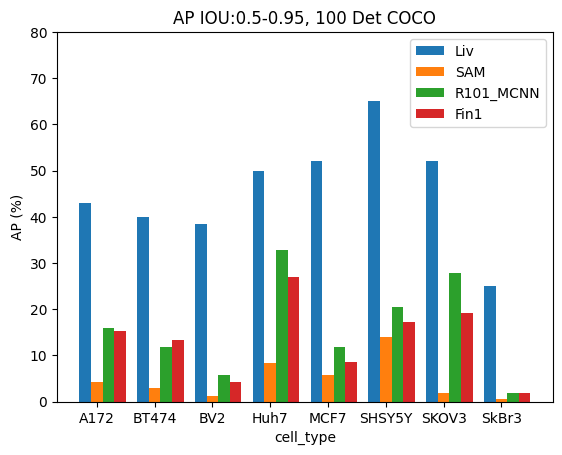

In [44]:
import matplotlib.pyplot as plt

fig = plt.figure()

# print(precision_labels)
X = np.arange(len(x_labels))
plt.bar(X - 0.2,precision_labels_liv, 0.2, label="Liv")
plt.bar(X,precision_labels, 0.2, label="SAM")
plt.bar(X + 0.2,precision_labels_d2, 0.2, label="R101_MCNN")
plt.bar(X + 0.4,precision_labels_fin1, 0.2, label="Fin1")
plt.xticks(X, x_labels)
plt.xlabel("cell_type")
plt.ylabel("AP (%)")
plt.title("AP IOU:0.5-0.95, 100 Det COCO")
plt.ylim(0, 80)
plt.legend()
plt.show()


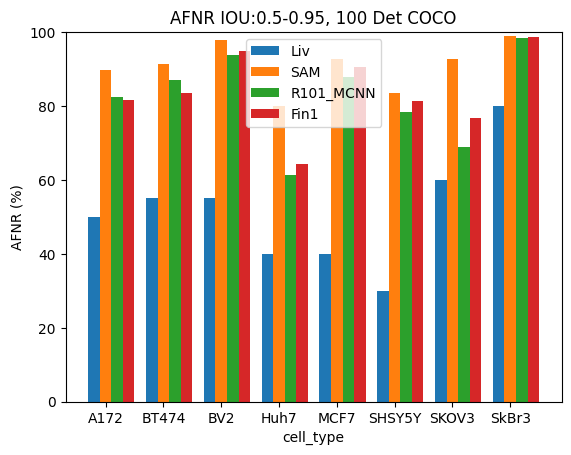

In [45]:
fig = plt.figure()

X = np.arange(len(x_labels))
plt.bar(X - 0.2,afnr_labels_liv, 0.2, label="Liv")
plt.bar(X,afnr_labels, 0.2, label="SAM")
plt.bar(X + 0.2,afnr_labels_d2, 0.2, label="R101_MCNN")
plt.bar(X + 0.4,afnr_labels_fin1, 0.2, label="Fin1")
plt.xticks(X, x_labels)
plt.xlabel("cell_type")
plt.ylabel("AFNR (%)")
plt.title("AFNR IOU:0.5-0.95, 100 Det COCO")
plt.ylim(0, 100)
plt.legend()
plt.show()